```
python 3.6, Matlab 2018b, PyTorch 1.4.0
```

### Libraries

In [150]:
%matplotlib inline
import numpy as np
import os
from glob import glob
# import cv2
# import skimage.io as skio
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from Utilities import patchify, BlockSet
from PIL import Image
# from sklearn.feature_extraction import image

### Load data

In [12]:
refDir = r'/media/banikr2/DATA/Diesel_block/4_refocus'
segDir = r'/media/banikr2/DATA/Diesel_block/5_segmented'
mskDir = r'/media/banikr2/DATA/Diesel_block/6_binarymask'
refFiles = sorted(glob(os.path.join(refDir, '*.tif')))#.sort()
segFiles = sorted(glob(os.path.join(segDir, '*.tif')))#.sort()
mskFiles = sorted(glob(os.path.join(mskDir, '*.png')))

Same number of image slices:

In [13]:
len(refFiles), len(segFiles), len(mskFiles)

(294, 294, 294)

In [157]:
im = Image.open(refFiles[20]).convert('RGB')
sg = Image.open(segFiles[20]).convert('RGB')
mk = Image.open(mskFiles[20]).convert('L') # L --> Load image as grayscale mode. 

``` works but PIL chosen
im = skio.imread(refFiles[20], plugin="tifffile")
sg = skio.imread(segFiles[20], plugin="tifffile")
mk = skio.imread(mskFiles[20])
```

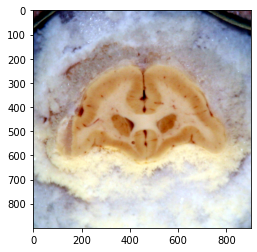

In [15]:
plt.imshow(im)
# plt.imshow(mk)

In [158]:
imarray = np.array(im) 
sgarray = np.array(sg)
mkarray = np.array(mk)

In [159]:
imarray.dtype, imarray.shape, sgarray.dtype, sgarray.shape, mkarray.dtype, mkarray.shape

(dtype('uint8'),
 (900, 900, 3),
 dtype('uint8'),
 (900, 900, 3),
 dtype('uint8'),
 (900, 900))

In [18]:
np.unique(mk)

array([  0, 255], dtype=uint8)

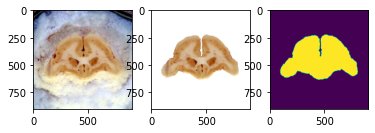

In [19]:
plt.subplot(131)
plt.imshow(im)
# plt.axis("off")
plt.subplot(132)
plt.imshow(sg)
# plt.axis("off")
plt.subplot(133)
plt.imshow(mk)
plt.show()

``` matlab
>> whos img21
  Name         Size                 Bytes  Class    Attributes

  img21      900x900x3            2430000  uint8  

>> whos seg21
  Name        Size                 Bytes  Class    Attributes
  seg21      900x900x3            2430000  uint8              
```

ground truth should be converted to a binary mask?<br> $0$ --> non-brain part of the slice <br> $1$ --> brain part of the slice

In [206]:
# sg_chunk = sg[250:400,200:350,:]
# plt.imshow(sg_chunk)

Convert to grayscale `rgb2gray` in *Matlab*

|<p>|<p>|<p>|<p>|
|:-:|:-:|:-:|:-:|
| <img src="../Images/rgb_21.jpg" style="width: 200px;"/> _slice #020_ |<img src="../Images/seg_21.jpg" style="width: 200px;"/> |<img src="../Images/grayscale_21.jpg" style="width: 200px;"/> |<img src="../Images/binarymask_21.jpg" style="width: 200px;"/>  |
| <img src="../Images/rgb_201.jpg" style="width: 200px;"/> _slice #200_|<img src="../Images/seg_201.jpg" style="width: 200px;"/>|<img src="../Images/grayscale_201.jpg" style="width: 200px;"/> |<img src="../Images/binarymask_201.jpg" style="width: 200px;"/>  |
|_refocused image(RGB)_|_segmented image(RGB)_|_grayscaled_|_binary mask_|

non-brain pixels were removed by `regionprops` _Matlab_

|<p>|<p>|
|:-:|:-:|
| <img src="../Images/binarymask_190.png" style="width: 200px;"/> |<img src="../Images/binarybrainmask_190.png" style="width: 200px;"/> |

patch size : `128,128,3` or `224,224,3` <br>
The following code should cover the whole image/mask given patchsize and stepsize

In [ ]:
def patchify(img, msk, patchsize, stepsize, retovermat=False, plotovermat=False):
    """
    img: image to patchify
    msk: binary mask to patchify
    patchsize: e.g. [100,100,3]
    step: for windown sliding e.g. [100,100]
    retovermat: return the overlap matrix, default = False
    plotovermat: visualize the patching, default = False
    """
    count=0
    imgPatch = []
    mskPatch = []
    overlapMat = np.zeros_like(img[..., 0])
    for r in range(0, img.shape[0]-patchsize[0], stepsize[0]):
        for c in range(0, img.shape[1]-patchsize[1], stepsize[1]):
            if c+stepsize[1]+patchsize[1] > img.shape[1]:
                print("{} {} Column ends".format(r, c))
                count += 1
                overlapMat[r:r+patchsize[0], img.shape[1]-patchsize[1]:img.shape[1]] += 1
                imgPatch.append(img[r:r+patchsize[0], img.shape[1]-patchsize[1]:img.shape[1], :])
                mskPatch.append(msk[r:r+patchsize[0], img.shape[1]-patchsize[1]:img.shape[1]])
            elif r+stepsize[0]+patchsize[0] > img.shape[0]:
                print("{} {} Row ends".format(r, c))
                count += 1
                overlapMat[img.shape[0]-patchsize[0]:img.shape[0], c:c+patchsize[1]] += 1
                imgPatch.append(img[img.shape[0]-patchsize[0]:img.shape[0], c:c+patchsize[1], :])
                mskPatch.append(msk[img.shape[0]-patchsize[0]:img.shape[0], c:c+patchsize[1]])
            elif r+stepsize[0]+patchsize[0] > img.shape[0] and c+stepsize[1]+patchsize[1] > img.shape[1]:
                print("{} {} Both end".format(r, c))
                count += 1
                overlapMat[img.shape[0]-patchsize[0]:img.shape[0], img.shape[1]-patchsize[1]:img.shape[1]] += 1
                imgPatch.append(img[img.shape[0]-patchsize[0]:img.shape[0], img.shape[1]-patchsize[1]:img.shape[1], :])
                mskPatch.append(msk[img.shape[0]-patchsize[0]:img.shape[0], img.shape[1]-patchsize[1]:img.shape[1]])
            else:
                print("{} {} Clear".format(r, c))
                count += 1
                overlapMat[r:r + patchsize[0], c:c + patchsize[1]] += 1
                imgPatch.append(img[r:r + patchsize[0], c:c + patchsize[1], :])
                mskPatch.append(msk[r:r + patchsize[0], c:c + patchsize[1]])
    print("Total patch: ", count)
    imgPatch = np.array(imgPatch).astype(img.dtype)
    mskPatch = np.array(mskPatch).astype(msk.dtype)
    if plotovermat:
        c = plt.imshow(overlapMat)
        plt.colorbar(c)
        plt.show()
    if retovermat:
        return imgPatch, mskPatch, overlapMat
    else:
        return imgPatch, mskPatch

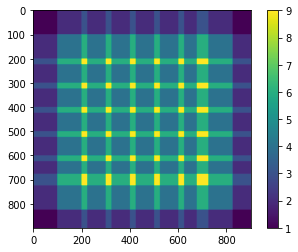

In [153]:
im = Image.open(refFiles[20]).convert('RGB')
mk = Image.open(mskFiles[20]).convert('L')
im = np.asarray(im)
mk = np.asarray(mk)
patchsize = [224, 224]
stepsize = [100, 100]
im, mk = patchify(im, mk, [224, 224], [100, 100])

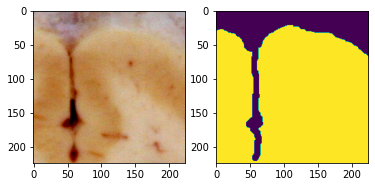

In [23]:
plt.subplot(121)
plt.imshow(i[20,...])
# plt.show()
plt.subplot(122)
plt.imshow(m[20,...])
plt.show()

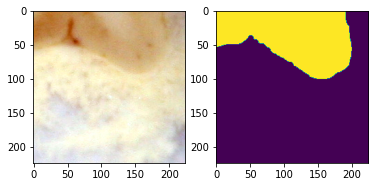

In [24]:
plt.subplot(121)
plt.imshow(i[46,...])
# plt.show()
plt.subplot(122)
plt.imshow(m[46,...])
plt.show()

In [62]:
im.dtype, mk.dtype, im.shape, type(im), type(mk), mk.shape

(dtype('uint8'),
 dtype('uint8'),
 (64, 224, 224, 3),
 numpy.ndarray,
 numpy.ndarray,
 (64, 224, 224))

In [142]:
im = np.transpose(im, (0, 3, 1, 2))
print(im.shape)

(64, 3, 224, 224)


In [143]:
im.max(), im.min(), im[24,...].shape

(255, 0, (3, 224, 224))

In [204]:
# PIL_image = Image.fromarray(im[34,...]).convert('RGB')
# PIL_mask = Image.fromarray(mk[34,...]).convert('L')

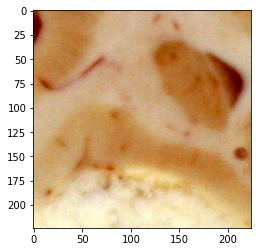

In [112]:
plt.imshow(PIL_image)

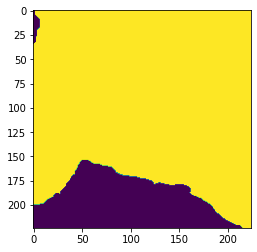

In [113]:
plt.imshow(PIL_mask)

In [101]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
T = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
#             normalize
])

In [202]:
# PIL_imgT, PIL_mskT = T(PIL_image, PIL_mask)
# PIL_mskT = T(PIL_mask)

In [97]:
PIL_imgT.max(), PIL_imgT.min(), PIL_mskT.max(), PIL_mskT.min()

(tensor(1.), tensor(0.), tensor(1.), tensor(0.))

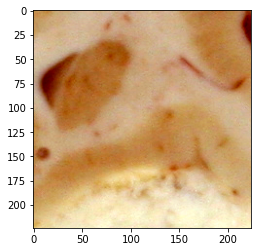

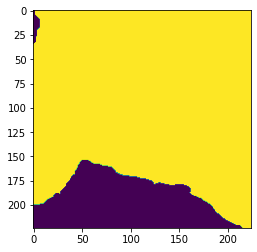

In [98]:
plt.imshow(PIL_imgT.numpy().transpose(1,2,0))
plt.show()
plt.imshow(PIL_mskT.numpy().transpose(1,2,0))

In [137]:
import torchvision.transforms.functional as TF
import random

def my_segmentation_transforms(image, segmentation):
    if random.random() > 0.1:
        angle = random.randint(-30, 30)
        image = TF.rotate(image, angle)
        segmentation = TF.rotate(segmentation, angle)
        
    image = transforms.ToTensor()(image)
    segmentation = transforms.ToTensor()(segmentation)
    # more transforms ...
    return image, segmentation

In [138]:
PIL_imgTF, PIL_mskTF = my_segmentation_transforms(PIL_image, PIL_mask)

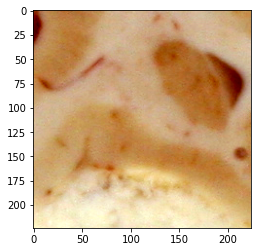

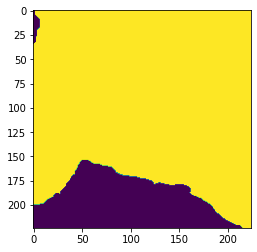

In [139]:
plt.imshow(PIL_imgTF.numpy().transpose(1,2,0))
plt.show()
plt.imshow(PIL_mskTF.numpy().transpose(1,2,0))

In [25]:
i.shape, m.shape, i.dtype, m.dtype, len(i), m.size

((64, 224, 224, 3),
 (64, 224, 224),
 dtype('uint8'),
 dtype('uint8'),
 64,
 3211264)

### Dataset/DataLoader
``` code are in and imported from
Utilities.py
```

In [30]:
from Utilities import BlockSet
unitSet = BlockSet(refFiles, mskFiles)

In [201]:
# refFiles, mskFiles

In [175]:
dataSet = {}
phases = ["train","valid"]
i = 90
# for phase in phases: 
#     i+=1
#     dataSet[phase]=i+19
dataSet[phases[0]] = i
print(dataSet)

{'train': 90}


In [196]:
import torch.nn as nn

In [194]:
y.dtype, prediction.dtype

(torch.int64, torch.float32)

In [179]:
all_loss

{'train': tensor([0.])}

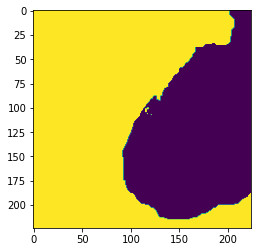

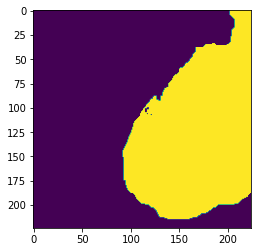

In [71]:
plt.imshow(mkout[0,32,...])
plt.show()
plt.imshow(mkout[1,32,...])
plt.show()

|<p>|
|:-:|
|<img src="../Images/Dicescoreon320.png" style="width: 400px;"/> |

``` python
FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
)
```

Not needed
``` python
patches = torch.tensor(sg).unfold(0, 128, 10).unfold(1, 128, 10).unfold(2, 3, 3)
print(patches.shape)
plt.imshow(patches[31,35,0,...])
plt.imshow(patches_[17,...])
plt.show()
plt.imshow(mskpatches[17,...])
```

### ToDo:
1. ~~Remove isolated pixels outside brain.~~
2. ~~Create binary/target masks for all the slices and datastructure...~~
3. ~~Tiling for image and masks.~~
4. Dataset/DataLoader in pytorch.
5. Network architecture: start with U-Net?
6. Loss function(binary cross entropy or ?)

### Questions/doubt:
1. In Blockset(Dataset) normalize before patching? How do I normalize RGB? globally or locally[4]? <br>
    -The mean and std values are usually calculated from all training images. Also you should pass them as normalized values, since `transforms.ToTensor()` will normalize your data so that the values are in the range [0, 1]. A division of the mean and std by 255. should be sufficient[2]. ImageNet mean and std[3] work quite well for normal images. 
 <br>   
2. How to validate the created binary masks? 
3. Save patches in a directory? or feed to the network from memory(_gradient accumulation_)
4. ~~There are small pixels scattered outside brain regions, do we need to remove those by erosion or other morphological operations?~~
 - ~~**caveats:** some slices have unit brain, some have two or three parts, _largest connected component_ may not work.~~

### Reference:
1. For normalization: https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/6?u=ptrblck (be careful reading this discussion, has errors)
2. Customized dataset for semantic segmentation: https://discuss.pytorch.org/t/how-make-customised-dataset-for-semantic-segmentation/30881/5
3. ImageNet: https://github.com/pytorch/examples/blob/91f230a13b95c6259e5cb22b6cef355de998cede/imagenet/main.py#L189
4. Whole or batch mean/std: https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949
5. For Transformation example: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
6. This project matches UNet and transformation: https://github.com/choosehappy/PytorchDigitalPathology/blob/master/segmentation_epistroma_unet/train_unet.ipynb